In [1]:
import math
import numpy as np
import pandas as pd
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score
import matplotlib.pyplot as plt
import json

from src.model import MockModel
from src.utils import index_for_arange, write_results, cq_labels, cq_filter
import src.plot as plot
from src.eval import (
    adjusted_classification_x_width_score,
    size_stratified_classification_coverage_score,
    cq_stats,
    set_size_equals,
)
from src.heuristics import TopKSelector, HeuristicCutoffSelector, TopKCutoffSelector

In [2]:
# load data
dataset = 'banking77'
intent_classifier = 'bert'
data_dir = f'data/{dataset}/{intent_classifier}/'

df_train_preds = pd.read_csv(data_dir + "train_predictions.csv")
df_test_preds = pd.read_csv(data_dir + "test_predictions.csv")
df_calibration_preds = pd.read_csv(data_dir + "calibration_predictions.csv")
df_atis_preds = pd.read_csv(data_dir + "atis_predictions.csv")

labels = pd.read_csv(data_dir+'/labels.csv', header=0, names=['index','label'])
labels = list(labels.label)
N_INTENTS = len(labels)

In [3]:
# check train-calibration-test split sizes
df_train_preds.shape[0], df_calibration_preds.shape[0], df_test_preds.shape[0]

(7849, 2617, 2617)

In [4]:
# apply some basic transformations
df_train = df_train_preds.reset_index().rename(columns={'index': 'utterance'})
df_test = df_test_preds.reset_index().rename(columns={'index': 'utterance'})
df_calibration = df_calibration_preds.reset_index().rename(columns={'index': 'utterance'})
df_atis = df_atis_preds.reset_index().rename(columns={'index': 'utterance'})


df_train['utterance'] = df_train['utterance'].apply(lambda h: 'train_' + str(h))
df_test['utterance'] = df_test['utterance'].apply(lambda h: 'test_' + str(h))
df_calibration['utterance'] = df_calibration['utterance'].apply(lambda h: 'cal_' + str(h))
df_atis['utterance'] = df_atis['utterance'].apply(lambda h: 'ood_' + str(h))


df_train['utterance'] = df_train['utterance'].astype(str)
df_test['utterance'] = df_test['utterance'].astype(str)
df_calibration['utterance'] = df_calibration['utterance'].astype(str)
df_atis['utterance'] = df_atis['utterance'].astype(str)

np.random.seed(42)
df_ood_shuffled = df_atis.sample(frac=1)
train_test_split_test = int(len(df_test)/2)
train_test_split_ood = int(len(df_test)/2)

df_test_shuffled = df_test.sample(frac=1)
df_ood_calib = pd.concat([df_test_shuffled[train_test_split_test:], df_ood_shuffled[train_test_split_ood:]])
df_ood_test = pd.concat([df_test_shuffled[:train_test_split_test], df_ood_shuffled[:train_test_split_ood]])


In [5]:
# merge datasets to single frame
fullset = pd.concat([df_test, df_calibration], ignore_index=True)
assert fullset.utterance.value_counts().max() == 1, "Hashes/utterances should be unique in full set"
fullset = fullset.drop(['label', 'hash', 'text'], axis=1)
fullset.head()

fullset_ood = pd.concat([df_ood_shuffled,df_test,df_calibration])
fullset_ood = fullset_ood.drop(['label', 'hash', 'text'], axis=1)


In [6]:
# parameters for evaluation
X_train = fullset[['utterance']]
X_calib = df_calibration[['utterance']]
X_test = df_test[['utterance']]

X_ood_calib = df_ood_calib[['utterance']]
X_ood_test = df_ood_test[['utterance']]


a_start = 0.01
a_stop = .4
a_step = 0.01
alpha = np.arange(a_start, a_stop, a_step)

max_ps_size = math.ceil(N_INTENTS * .25)
max_ps_size = 7

target_alpha = .01
target_index = index_for_arange(a_start, a_step ,target_alpha)

In [7]:
# instantiate a mock sklearn model which simply looks up the results in a lookup table
model = MockModel(fullset, 'utterance', softmax=False)
model_ood = MockModel(fullset_ood, 'utterance', softmax=False)
# fit the test dataset
model.fit(X_test, df_test['label'])
# model_ood.fit(X_ood, df_ood['label'])
# extract the test targets from the datasets
y_test = df_test['label'].apply(lambda lbl: list(model.classes_).index(lbl))
y_ood = df_ood['label']

NameError: name 'df_ood' is not defined

In [ ]:
# marginal conformal prediction
mapie_marginal = MapieClassifier(estimator=model, cv="prefit", method="score", random_state=42)
mapie_marginal.fit(X_calib, df_calibration['label'])
y_pred_marginal, y_ps_marginal = mapie_marginal.predict(X_test, alpha=alpha)


coverages_marginal = [
    classification_coverage_score(y_test, y_ps_marginal[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_marginal = [
    adjusted_classification_x_width_score(y_ps_marginal[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_marginal = [
    set_size_equals(y_ps_marginal[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_marginal = [
    (y_ps_marginal[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_marginal = [
    size_stratified_classification_coverage_score(y_test, y_ps_marginal[:, :, i])
    for i, _ in enumerate(alpha)
]

results = cq_stats(y_ps_marginal[:, :, target_index], y_test, max_ps_size)

write_results('banking77-bert-cicc', dataset, intent_classifier, 'cicc', results)
results

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9814595660749507,
 0.7856324035154757,
 2.8997912317327765,
 0.03591899121131066)

In [ ]:
# adaptive conformal prediction
mapie_adaptive = MapieClassifier(estimator=model, cv="prefit", method="cumulated_score", random_state=42)
mapie_adaptive.fit(X_calib, df_calibration['label'])
y_pred_adaptive, y_ps_adaptive = mapie_adaptive.predict(X_test, alpha=alpha)


coverages_adaptive = [
    classification_coverage_score(y_test, y_ps_adaptive[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_adaptive = [
    adjusted_classification_x_width_score(y_ps_adaptive[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_adaptive = [
    set_size_equals(y_ps_adaptive[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_adaptive = [
    (y_ps_adaptive[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_adaptive = [
    size_stratified_classification_coverage_score(y_test, y_ps_adaptive[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_adaptive[:, :, target_index], y_test, max_ps_size)

(0.9852445193929174,
 0.8012991975544517,
 3.021818181818182,
 0.09858616736721437)

In [ ]:
# TOP-K conformal prediction
mapie_topk = MapieClassifier(estimator=model, cv="prefit", method="top_k", random_state=42)
mapie_topk.fit(X_calib, df_calibration['label'])
y_pred_topk, y_ps_topk = mapie_topk.predict(X_test, alpha=alpha)


coverages_topk = [
    classification_coverage_score(y_test, y_ps_topk[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_topk = [
    adjusted_classification_x_width_score(y_ps_topk[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_topk = [
    set_size_equals(y_ps_topk[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_topk = [
    (y_ps_topk[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_topk = [
    size_stratified_classification_coverage_score(y_test, y_ps_topk[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_topk[:, :, target_index], y_test, max_ps_size)

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9881543752388231, 0.0, 5.0, 0.0)

In [ ]:
# RAPS
mapie_raps = MapieClassifier(estimator=model, cv="prefit", method="raps")
mapie_raps.fit(X_calib, df_calibration['label'])
y_pred_raps, y_ps_raps = mapie_raps.predict(X_test, alpha=alpha)


coverages_raps = [
    classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_raps = [
    adjusted_classification_x_width_score(y_ps_raps[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_raps = [
    set_size_equals(y_ps_raps[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_raps = [
    (y_ps_raps[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_raps = [
    size_stratified_classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_raps[:, :, target_index], y_test, max_ps_size)

(0.9847153228888039, 0.5487199082919373, 4.266723116003387, 0.0)

In [ ]:
# heuristic 1: select all classes above a certain cutoff or the top-5 if there are none
topk_cutoff = TopKCutoffSelector(estimator=model, cutoff=1-target_alpha, k=5)
y_ps_h1 = topk_cutoff.predict(X_test)
results = cq_stats(y_ps_h1, y_test, max_ps_size)
write_results('banking77-bert-h1', dataset, intent_classifier, 'h1', results)
results

(0.9701948796331678, 0.9044707680550248, 5.0, 0.0)

In [ ]:
top_95 = HeuristicCutoffSelector(estimator=model, cutoff=1-target_alpha)
y_ps_h2 = top_95.predict(X_test)
results = cq_stats(y_ps_h2, y_test, max_ps_size)
write_results('banking77-bert-h2', dataset, intent_classifier, 'h2', results)
results

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9323653037829576, 1.0, nan, 0.0)

In [ ]:
topk_5 = TopKSelector(estimator=model, k=5)
y_ps_h3 = topk_5.predict(X_test)

results = cq_stats(y_ps_h3, y_test, max_ps_size)
write_results('banking77-bert-h3', dataset, intent_classifier, 'h3', results)
results

(0.9881543752388231, 0.0, 5.0, 0.0)

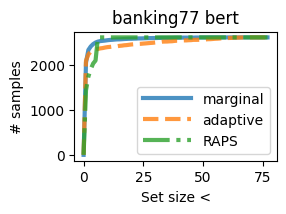

In [ ]:
to_plot = [
    (y_ps_marginal, 'marginal', '-', None),
    (y_ps_adaptive, 'adaptive', '--', None),
    (y_ps_raps, 'RAPS', '-.', None),
    # (y_ps_topkmapie, 'TOPK', ':', None),
    # (y_ps_top_5_95, 'heuristic a', 'dashed', 'black'),
    # (y_ps_top_95,  'heuristic b', 'dotted', 'black'),
    # (y_ps_topk_5,  'heuristic c', '-.', 'black'),
]
fig, ax = plt.subplots(1, 1, figsize=plot.fig_dim_1)
for (resultset, label, style, color) in to_plot:
    if len(label) > len('heuristic') and label[:len('heuristic')] == 'heuristic':
        to_plot_result = resultset
    else:
        to_plot_result = resultset[:, :, target_index]
    ax.plot(
        np.cumsum([set_size_equals(to_plot_result, i) for i in range(78)]),
        label=label,
        linestyle=style,
        color=color,
        linewidth=3,
        alpha=.8)
    # ax.set_xscale('log')
plt.xlabel('Set size <')
plt.ylabel('# samples')
plt.title(f'{dataset} {intent_classifier}'.format(target_alpha))
plt.legend(handlelength=3.5)
plt.tight_layout()
plt.savefig(f'results/cum_set_size_{dataset}_{intent_classifier}.png', dpi=1200)

In [ ]:
y_ps_which = y_ps_marginal
ambiguous_indices = np.where((y_ps_which[:, :, target_index].sum(axis=1) > max_ps_size))
ambiguous = df_test.loc[ambiguous_indices]
len(list(zip(ambiguous.index,[ labels[l] for l in ambiguous.label.tolist()], ambiguous.text.tolist())))

82

In [ ]:
for a in ambiguous.index:
    alternatives = np.where(y_ps_which[a, :, target_index])[0]
    print(" & ".join([ambiguous.loc[a].text, labels[ambiguous.loc[a].label].replace("_", " "), ', '.join([labels[l].replace("_", " ") for l in alternatives])]) + " \\\\")

what is the matter? & direct debit payment not recognised & activate my card, age limit, balance not updated after bank transfer, balance not updated after cheque or cash deposit, beneficiary not allowed, cancel transfer, card arrival, card delivery estimate, card not working, card swallowed, cash withdrawal not recognised, change pin, compromised card, contactless not working, country support, declined card payment, declined transfer, direct debit payment not recognised, exchange rate, failed transfer, get physical card, lost or stolen card, lost or stolen phone, pending card payment, pending cash withdrawal, pending transfer, pin blocked, Refund not showing up, reverted card payment?, terminate account, top up failed, top up reverted, transaction charged twice, transfer not received by recipient, transfer timing, unable to verify identity, why verify identity, wrong amount of cash received \\
Can I choose when my card is delivered? & card delivery estimate & activate my card, card ab

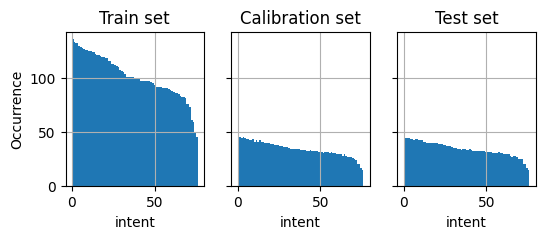

In [ ]:
label_sorting_map = {i: x for x, i in enumerate(df_train.label.value_counts(sort=True).index)}
for i in range(len(labels)):
    if i not in label_sorting_map:
        label_sorting_map[i] = len(label_sorting_map)
fig, axs = plt.subplots(1,3,figsize=(plot.fig_width_in * 2, 2), sharey=True)
pd.Series(list(map(lambda x: label_sorting_map[x], df_train.label, ))).hist(bins=N_INTENTS, ax=axs[0])
pd.Series(list(map(lambda x: label_sorting_map[x], df_calibration.label, ))).hist(bins=N_INTENTS, ax=axs[1])
pd.Series(list(map(lambda x: label_sorting_map[x], df_test.label, ))).hist(bins=N_INTENTS, ax=axs[2])
titles = ['Train set', 'Calibration set', 'Test set']
[ax.set_xlabel('intent') for ax in axs]
[ax.set_title(title) for (ax, title) in zip(axs, titles)]
axs[0].set_ylabel('Occurrence')
# plt.yticks([]) 
plt.savefig(f"results/label_distribution_{dataset}.png", dpi=1200)
plt.show()

In [ ]:
cq_inputs = df_test[cq_filter(y_ps_marginal[:, :, target_index], max_ps_size)].text
cq_lbls = cq_labels(y_ps_marginal[:, :, target_index], max_ps_size, labels)

cqs = []
for i, (text, lbls) in enumerate(zip(cq_inputs, cq_lbls)):
    cqs.append({
        "id": i,
        "text": text,
        "predictions": lbls,
    })

with open(f'results/clarification_questions_{dataset}_{intent_classifier}.json', 'w') as f:
    json.dump(cqs, f, indent=4)

In [ ]:
pd.Series(np.cumsum([set_size_equals(y_ps_adaptive[:, :, target_index], i) for i in range(N_INTENTS+1)])).to_csv(f'results/cum_{dataset}_{intent_classifier}.csv')

In [ ]:
def to_oos(y_pred_set, max_ps_size):
    return y_pred_set.sum(axis=1) > max_ps_size

def to_oos_score(y_pred_set):
    return y_pred_set.sum(axis=1) / N_INTENTS

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay

mapie_marginal_ood = MapieClassifier(estimator=model_ood, cv="prefit", method="score", random_state=42)
mapie_marginal_ood.fit(X_calib, df_calibration['label'])

a_start = 1 / y_ood.shape[0]
a_stop = .01
a_step = 0.001
alpha = np.arange(a_start, a_stop, a_step)
y_pred_marginal_ood, y_ps_marginal_ood = mapie_marginal_ood.predict(X_ood, alpha=alpha)

f1s = []
aucs = []
for i in range(len(alpha)):
    target_index_ood = i

    y_pred_ood = to_oos(y_ps_marginal_ood[:, :, target_index_ood], max_ps_size)
    y_preds_ood = [to_oos(y_ps_marginal_ood[:, :, target_index_ood], max_ps_size) for max_ps_size in range(12)]

    y_pred_ood_score = to_oos_score(y_ps_marginal_ood[:, :, target_index_ood])
    y_true_ood = y_ood_calib == oos_label

    y_preds_ood_f1s = [f1_score(y_true_ood, pred) for pred in y_preds_ood]
    f1s.append(max(y_preds_ood_f1s))
    aucs.append(roc_auc_score(y_true_ood, y_pred_ood_score))

f1s = np.array(f1s)
aucs = np.array(aucs)

selected_alpha_index = f1s.argmax()
print(f"select alpha = {alpha[selected_alpha_index]} at index {selected_alpha_index} with f1 = {f1s[selected_alpha_index]} and auc = {aucs[selected_alpha_index]}")

/Users/floris/miniconda3/envs/cicc/lib/python3.12/site-packages/mapie/classification.py:956: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 78 unique labels while calibration have 77 unique labels
  warnings.warn(


NameError: name 'X_ood_calib' is not defined

In [ ]:
f1s = np.array(f1s)

y_pred_ood = to_oos(y_ps_marginal_ood[:, :, selected_alpha_index], max_ps_size)
y_preds_ood = [to_oos(y_ps_marginal_ood[:, :, selected_alpha_index], max_ps_size) for max_ps_size in range(50)]

y_pred_ood_score = to_oos_score(y_ps_marginal_ood[:, :, 1])
y_true_ood = y_ood_calib == oos_label
y_preds_ood_f1s = [f1_score(y_true_ood, pred) for pred in y_preds_ood]
optimal_threshold = np.array(y_preds_ood_f1s).argmax()
print(f"optimal threshold at {optimal_threshold} in calibration set")

In [ ]:
# marginal conformal prediction
mapie_marginal_ood = MapieClassifier(estimator=model_ood, cv="prefit", method="score", random_state=42)
mapie_marginal_ood.fit(X_calib, df_calibration['label'])

a_start = 1 / y_ood.shape[0]
a_stop = .01
a_step = 0.001
alpha = np.arange(a_start, a_stop, a_step)
y_pred_marginal_ood, y_ps_marginal_ood = mapie_marginal_ood.predict(X_ood_test, alpha=alpha)

target_index_ood = selected_alpha_index

y_pred_ood = to_oos(y_ps_marginal_ood[:, :, target_index_ood], optimal_threshold)
y_preds_ood = [to_oos(y_ps_marginal_ood[:, :, target_index_ood], max_ps_size) for max_ps_size in range(50)]

y_pred_ood_score = to_oos_score(y_ps_marginal_ood[:, :, target_index_ood])
y_true_ood = y_ood_test == oos_label

y_preds_ood_f1s = [f1_score(y_true_ood, pred) for pred in y_preds_ood]
f1_ood_test = f1_score(y_true_ood, y_pred_ood)
auc_ood_test = roc_auc_score(y_true_ood, y_pred_ood_score)
print(f"F1 OOD on test set: {f1_ood_test}, AUC OOD on test set: {auc_ood_test}")
